# Cell-Cell Communication using Spatially informed Bivariate metrics  

Computation of local scores implemented in LIANA+. These scores are used to identify spatially co-expressed ligand-receptor pairs. However, they are also applicable to other types of spatially-informed bivariate analyses. 

### Load packages  

Environment ``liana``

In [1]:
# Generic
import pandas as pd
import numpy as np

# single cell
import scanpy as sc
import squidpy as sq
import anndata as ad
import decoupler as dc
import plotnine as p9
import liana as li

### Load and normalize data

In [2]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
files   = ['s1_covet_niche_def_corr_per_fov.h5ad','s2_covet_niche_def_corr_per_fov.h5ad','s3_covet_niche_def_corr_per_fov.h5ad']

s1 = sc.read_h5ad(folder+files[0])
#s1.obs["fov"] = s1.obs["fov"].astype(str) + "_s1"
s2 = sc.read_h5ad(folder+files[1])
#s2.obs["fov"] = s2.obs["fov"].astype(str) + "_s2"
s3 = sc.read_h5ad(folder+files[2])
#s3.obs["fov"] = s3.obs["fov"].astype(str) + "_s3"

adata = ad.concat([s1, s2, s3], join='outer',uns_merge='same',axis=0,pairwise=True) 
del s1 
del s2
del s3
adata

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 386727 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label'
    uns: 'CellTypes_max_colors', 'Niche_label_colors', 'cell_type_coarse_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial'
    obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sqrt-n_neighbors=30', 'covet_sqrt_flat-n_neighbors=30', 'spatial', 'spati

In [3]:
adata.X.max(),adata.layers['counts'].max()

(122.07407, 325)

The data is already normalized

### Background   

The idea is to use spatially-informed bivariate metrics to assess the spatial relationship between two variables. Specifically, we focus on local bivariate similarity metrics. In contrast to other spatial Methods, including Misty; focusing on local spatial relationships enables us to pinpoint the exact location of spatial relationships, and to identify spatial relationships that might occur only in a specific sub-region of our samples.

The authors of Liana+ saw that on average when used to identify local ligand-receptor relationships, spatially-weighted Cosine similarity did best. However, they expect that other scoring functions might be better suited for other tasks, e.g. Spatially-weighted Jaccard Similarity should be well suited for categorical data.

### Available local funtions

In [4]:
li.mt.bivariate.show_functions()

name                                   metadata  \
0          pearson   weighted Pearson correlation coefficient   
1         spearman  weighted Spearman correlation coefficient   
2           cosine                 weighted Cosine similarity   
3          jaccard                weighted Jaccard similarity   
4          product                    simple weighted product   
5     norm_product                normalized weighted product   
6           morans                                  Moran's R   
7  masked_spearman     masked & weighted Spearman correlation   

                                           reference  
0                                               None  
1                                               None  
2                                               None  
3                                               None  
4  If vars are z-scaled = Lee's static (Lee 2021;...  
5                                               None  
6  Li, Z., Wang, T., Liu, P. and Huang, Y., 2022....  
7  Ghazanfar, S., Lin, Y., Su, X., Lin, D.M., Pat...

The local functions work are quite simple, as they are simply weighted versions of well-known similarity metrics. The way that spatially-informed methods usually work is by making use of weights based on the proximity (or spatial connectivity) between spots/cells.  

The spatial weights in LIANA+ are by default defined as a family of radial kernels that use the inverse Euclidean distance between cells/spots to bind the weights between 0 and 1, with spots that are closest having the highest spatial connectivity to one another (1), while those that are thought to be too far to be in contact are assigned 0.  

LIANA’s connectivities are flexible and can be defined in any way that fits the user. The authors have thus aligned LIANA’s ```spatial_neighbors``` function to Squidpy’s ```spatial_neighbors``` function. A perfectly viable solution would be to use Squidpy’s nearest neighbors graph, which one can use to easily replace LIANA’s radial kernel connecitivies.  

In this case it's more suitable to use neighbors from squidpy, because they can be computed per fov. 

In [5]:
adata.obs['fov_unique'] = adata.obs.fov.astype(str) + '_' + adata.obs.slide.astype(str)
adata.obs['fov_unique'] = adata.obs['fov_unique'].astype('category')

In [6]:
sq.gr.spatial_neighbors(adata, spatial_key='spatial',library_key='fov_unique',n_neighs=30)#,delaunay=True)
adata

AnnData object with n_obs × n_vars = 386727 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label', 'fov_unique'
    uns: 'CellTypes_max_colors', 'Niche_label_colors', 'cell_type_coarse_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial', 'spatial_neighbors'
    obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sqrt-n_neighbors=30', 'covet_sqrt_flat

### Bivariate Ligand-Receptor Relationships  

Let’s see how these scores look for potential ligand-receptor interactions. Note that LIANA+ will take the presence of heteromeric complexes into account at the individual spot-level!

I computed only for two representative fovs. Otherwise, we need more memory

In [18]:
fovs = ['10_Run5211_S1','12_Run5211_S1']

In [30]:
list(adata.obs.fov_unique.cat.categories).index('18_Run5211_S3')

26

In [8]:
adatas = []
for i in adata.obs.fov_unique.cat.categories:
    #fov = str(i+1)
    adata_sub = adata[adata.obs['fov_unique'] == i]
    li.mt.bivariate(adata_sub,
                    resource_name='consensus', # NOTE: uses HUMAN gene symbols!
                    local_name='cosine', # Name of the function
                    global_name="morans", # Name global function
                    n_perms=100, # Number of permutations to calculate a p-value
                    mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
                    add_categories=True, # Whether to add local categories to the results
                    nz_prop=0.1, # Minimum expr. proportion for ligands/receptors and their subunits
                    use_raw=False,
                    verbose=True
                    )
    adatas.append(adata_sub)

Using `.X`!
Converting to sparse csr matrix!
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
Using resource `consensus`.
100%|██████████| 100/100 [00:02<00:00, 33.62it/s]
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/liana/method/sp/_bivariate/_spatial_bivariate.py:343: ImplicitModificationWarning: Setting element `.obsm['local_scores']` of view, initializing view as actual.
Using `.X`!
Converting to sparse csr matrix!
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
Using resource `consensus`.
100%|██████████| 100/100 [00:04<00:00, 20.84it/s]
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/liana/method/sp/_bivariate/_spatial_bivariate.py:343: ImplicitModificationWar

Now that this is done, we can extract and explore the newly-created AnnData object that counts our local scores (stored as an AnnData in ```.obsm```)

In [ ]:
lradata = ad.concat(adatas, join='outer',uns_merge='same',axis=0,pairwise=True) 
lradata

In [9]:
len(adatas)

71

In [31]:
lrdata_t1 = adatas[70].obsm['local_scores']# 9_Run5211_S3
lrdata_nd = adatas[26].obsm['local_scores']# 18_Run5211_S3

In addition to the local bivariate scores, we can also get the “global” scores for each pair of variables, which we can use to choose the best pairs of variables to visualize. Moreover, a useful property of Bivariate Moran’s R is that it is bound between -1 (perfect negative spatial co-expression) and 1 (perfect positive spatial co-expression). Thus, it can be used to identify pairs of variables that are spatially clustered together or apart.

#### T1D FOV

In [40]:
lrdata_t1.var.sort_values("mean", ascending=False).head(5)

ligand receptor  ligand_means  ligand_props  receptor_means  \
interaction                                                                
COL9A2^CD44  COL9A2     CD44      0.691589      0.538174        0.502764   
MMP7^CD44      MMP7     CD44      0.262433      0.226168        0.502764   
APP^CD74        APP     CD74      0.551760      0.436089        1.784687   
ARF1^INSR      ARF1     INSR      0.351239      0.362617        0.656016   
VIM^CD44        VIM     CD44      0.769304      0.481093        0.502764   

             receptor_props    morans  morans_pvals      mean       std  
interaction                                                              
COL9A2^CD44        0.406758  0.002874          0.20  0.355349  0.181866  
MMP7^CD44          0.406758  0.045563          0.00  0.351248  0.238221  
APP^CD74           0.647879 -0.011044          0.00  0.343484  0.162363  
ARF1^INSR          0.502372  0.003599          0.12  0.340529  0.168915  
VIM^CD44           0.406758  0.033414          0.00  0.322683  0.183042

In [41]:
lrdata_t1.var.sort_values("std", ascending=False).head(5)

ligand receptor  ligand_means  ligand_props  receptor_means  \
interaction                                                                   
CD14^ITGB2        CD14    ITGB2      0.132988      0.137455        0.232466   
MMP7^CD44         MMP7     CD44      0.262433      0.226168        0.502764   
COL18A1^ITGA3  COL18A1    ITGA3      0.403050      0.297628        0.148344   
S100A9^ITGB2    S100A9    ITGB2      0.177570      0.198131        0.232466   
TGFB1^ITGB5      TGFB1    ITGB5      0.090005      0.106686        0.118634   

               receptor_props    morans  morans_pvals      mean       std  
interaction                                                                
CD14^ITGB2           0.198275  0.023668          0.00  0.286931  0.277912  
MMP7^CD44            0.406758  0.045563          0.00  0.351248  0.238221  
COL18A1^ITGA3        0.179727  0.008291          0.00  0.274267  0.227696  
S100A9^ITGB2         0.198275  0.012038          0.00  0.215568  0.221511  
TGFB1^ITGB5          0.144932  0.000795          0.75  0.141274  0.218521

In [34]:
lrdata_t1.var.sort_values("morans", ascending=False).head()

ligand     receptor  ligand_means  ligand_props  \
interaction                                                        
MMP7^CD44          MMP7         CD44      0.262433      0.226168   
VIM^CD44            VIM         CD44      0.769304      0.481093   
CD14^ITGB2         CD14        ITGB2      0.132988      0.137455   
SPP1^CD44          SPP1         CD44      0.357560      0.234364   
SPP1^ITGAV_ITGB1   SPP1  ITGAV_ITGB1      0.357560      0.234364   

                  receptor_means  receptor_props    morans  morans_pvals  \
interaction                                                                
MMP7^CD44               0.502764        0.406758  0.045563           0.0   
VIM^CD44                0.502764        0.406758  0.033414           0.0   
CD14^ITGB2              0.232466        0.198275  0.023668           0.0   
SPP1^CD44               0.502764        0.406758  0.022824           0.0   
SPP1^ITGAV_ITGB1        0.074227        0.114738  0.022711           0.0   

                      mean       std  
interaction                           
MMP7^CD44         0.351248  0.238221  
VIM^CD44          0.322683  0.183042  
CD14^ITGB2        0.286931  0.277912  
SPP1^CD44         0.250379  0.185201  
SPP1^ITGAV_ITGB1  0.160032  0.201233

In [35]:
lrdata_t1.obs.fov_unique

1_9       9_Run5211_S3
2_9       9_Run5211_S3
3_9       9_Run5211_S3
4_9       9_Run5211_S3
5_9       9_Run5211_S3
              ...     
6956_9    9_Run5211_S3
6957_9    9_Run5211_S3
6958_9    9_Run5211_S3
6959_9    9_Run5211_S3
6960_9    9_Run5211_S3
Name: fov_unique, Length: 6955, dtype: category
Categories (1, object): ['9_Run5211_S3']

... storing 'ligand' as categorical
... storing 'receptor' as categorical


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


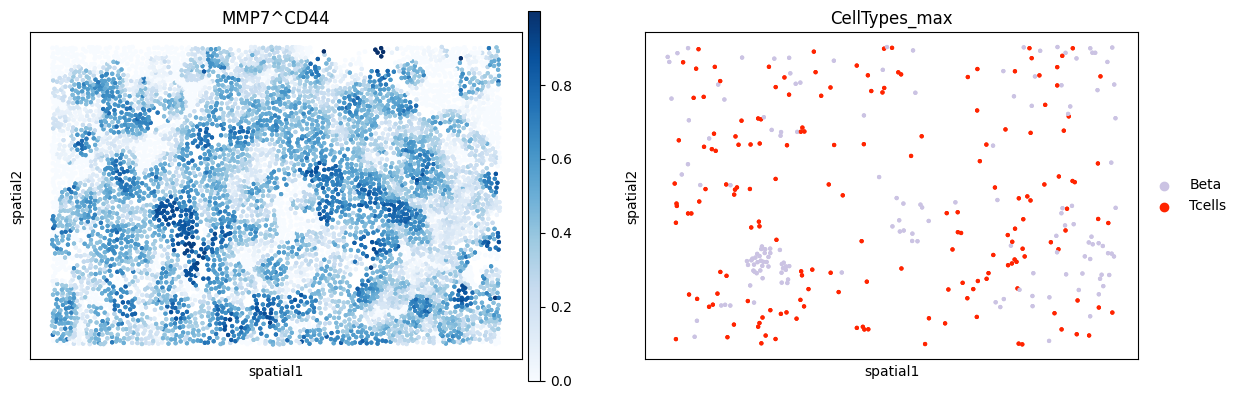

In [36]:
# HLA class II histocompatibility antigen gamma chain also known as HLA-DR antigens-associated invariant chain or CD74
sq.pl.spatial_scatter(
    lrdata_t1,
    color = ['MMP7^CD44', 'CellTypes_max'],
    groups = ['Beta','Tcells'],
    spatial_key = 'spatial',
    shape=None,
    cmap='Blues',
    ncols=2,
    #vmax="p99",
)

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


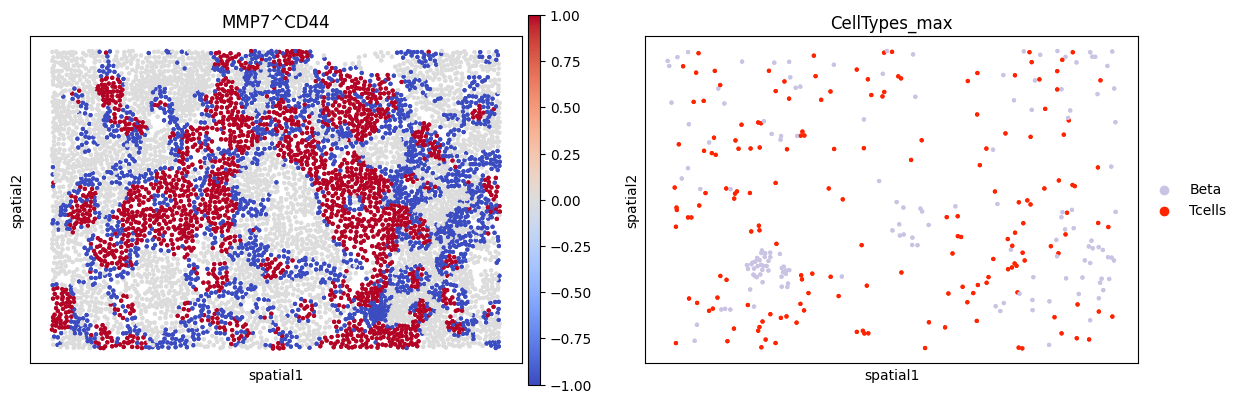

In [37]:
# Check how the TF activities look like
sq.pl.spatial_scatter(
    lrdata_t1,
    layer='cats',
    color = ['MMP7^CD44','CellTypes_max'],
    groups = ['Beta','Tcells'],
    spatial_key = 'spatial',
    shape=None,
    cmap='coolwarm',
    ncols=2,
    #vmax="p99",
)

Here, we can distinguish areas in which the interaction between interaction members is positive (high-high) in Red (1), while interactions in which one is high the other is low or negative (High-low) are in Blue (-1). We also see that some interactions are neither, these are predominantly interactions in which both members are lowly-expressed (i.e. low-low); we see those in white (0).

In [38]:
lrdata_t1

AnnData object with n_obs × n_vars = 6955 × 100
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label', 'fov_unique'
    var: 'ligand', 'receptor', 'ligand_means', 'ligand_props', 'receptor_means', 'receptor_props', 'morans', 'morans_pvals', 'mean', 'std'
    uns: 'CellTypes_max_colors', 'Niche_label_colors', 'cell_type_coarse_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors',

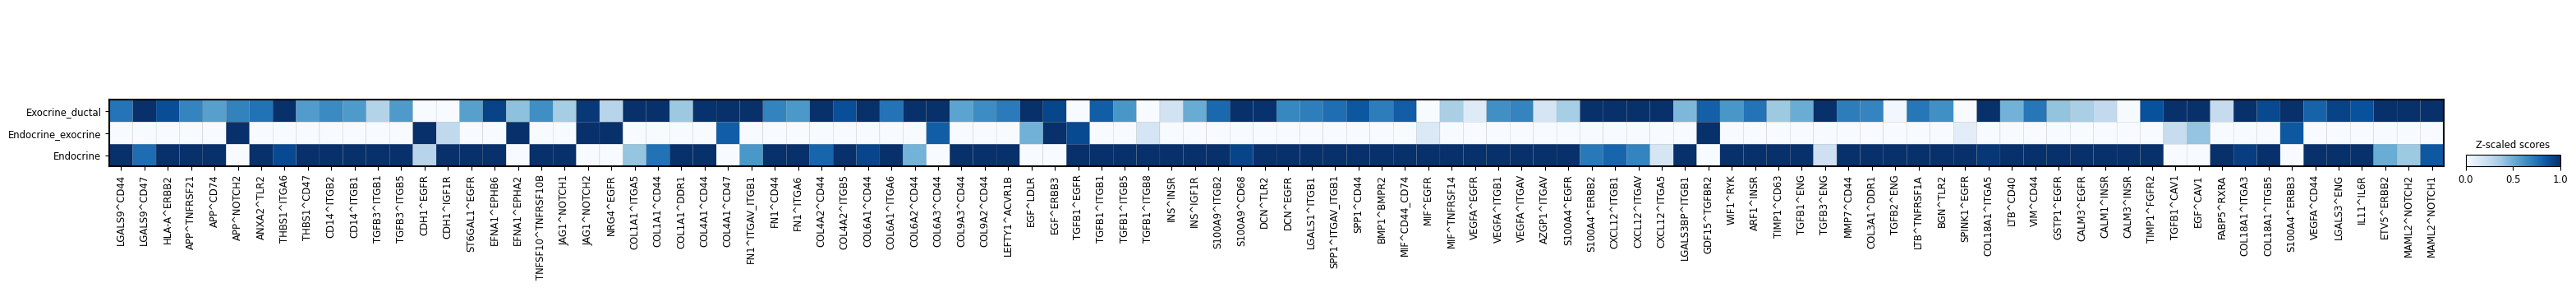

In [39]:
sc.pl.matrixplot(lrdata_t1, var_names=lrdata_t1.var_names, groupby='Niche_label', dendrogram=False, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Blues')

#### ND FOV

In [42]:
lrdata_nd.var.sort_values("mean", ascending=False).head(5)

ligand receptor  ligand_means  ligand_props  receptor_means  \
interaction                                                               
INS^INSR       INS     INSR      3.750615      0.289789        0.539003   
INS^IGF1R      INS    IGF1R      3.750615      0.289789        0.245563   
SPP1^CD44     SPP1     CD44      0.234303      0.126260        0.179529   
ARF1^INSR     ARF1     INSR      0.278851      0.167903        0.539003   
VEGFA^CD44   VEGFA     CD44      0.298895      0.166381        0.179529   

             receptor_props    morans  morans_pvals      mean       std  
interaction                                                              
INS^INSR           0.269633 -0.023404          0.00  0.176183  0.177266  
INS^IGF1R          0.149268  0.025689          0.00  0.166713  0.201253  
SPP1^CD44          0.112189  0.006034          0.03  0.151380  0.232897  
ARF1^INSR          0.269633 -0.002885          0.31  0.150141  0.169254  
VEGFA^CD44         0.112189 -0.003060          0.24  0.140533  0.212005

In [43]:
lrdata_nd.var.sort_values("std", ascending=False).head(5)

ligand receptor  ligand_means  ligand_props  receptor_means  \
interaction                                                               
SPP1^CD44     SPP1     CD44      0.234303      0.126260        0.179529   
VEGFA^CD44   VEGFA     CD44      0.298895      0.166381        0.179529   
VEGFA^ITGB1  VEGFA    ITGB1      0.298895      0.166381        0.196303   
APP^CD74       APP     CD74      0.313547      0.182925        0.287513   
INS^IGF1R      INS    IGF1R      3.750615      0.289789        0.245563   

             receptor_props    morans  morans_pvals      mean       std  
interaction                                                              
SPP1^CD44          0.112189  0.006034          0.03  0.151380  0.232897  
VEGFA^CD44         0.112189 -0.003060          0.24  0.140533  0.212005  
VEGFA^ITGB1        0.116942  0.009676          0.00  0.135785  0.207862  
APP^CD74           0.112759  0.007981          0.00  0.137036  0.201481  
INS^IGF1R          0.149268  0.025689          0.00  0.166713  0.201253

In [44]:
lrdata_nd.var.sort_values("morans", ascending=False).head()

ligand receptor  ligand_means  ligand_props  receptor_means  \
interaction                                                               
INS^IGF1R      INS    IGF1R      3.750615      0.289789        0.245563   
VEGFA^ITGB1  VEGFA    ITGB1      0.298895      0.166381        0.196303   
APP^CD74       APP     CD74      0.313547      0.182925        0.287513   
SPP1^CD44     SPP1     CD44      0.234303      0.126260        0.179529   
VIM^CD44       VIM     CD44      0.577476      0.265069        0.179529   

             receptor_props    morans  morans_pvals      mean       std  
interaction                                                              
INS^IGF1R          0.149268  0.025689          0.00  0.166713  0.201253  
VEGFA^ITGB1        0.116942  0.009676          0.00  0.135785  0.207862  
APP^CD74           0.112759  0.007981          0.00  0.137036  0.201481  
SPP1^CD44          0.112189  0.006034          0.03  0.151380  0.232897  
VIM^CD44           0.112189  0.002668          0.33  0.127917  0.179300

... storing 'ligand' as categorical
... storing 'receptor' as categorical


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


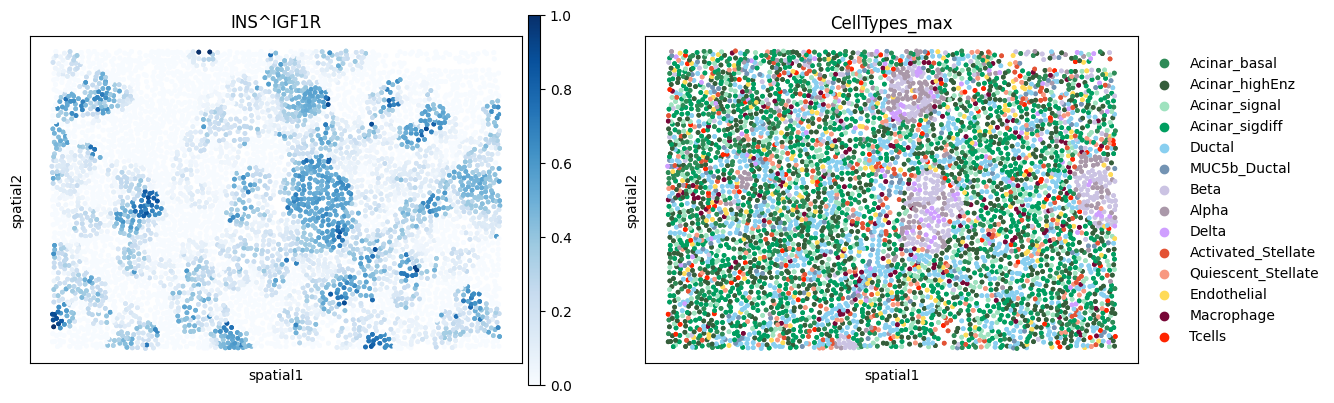

In [45]:
# Check how the TF activities look like
sq.pl.spatial_scatter(
    lrdata_nd,
    color = ['INS^IGF1R', 'CellTypes_max'],
    #groups = ['Endocrine'],
    spatial_key = 'spatial',
    shape=None,
    cmap='Blues',
    ncols=2,
    #vmax="p99",
)

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


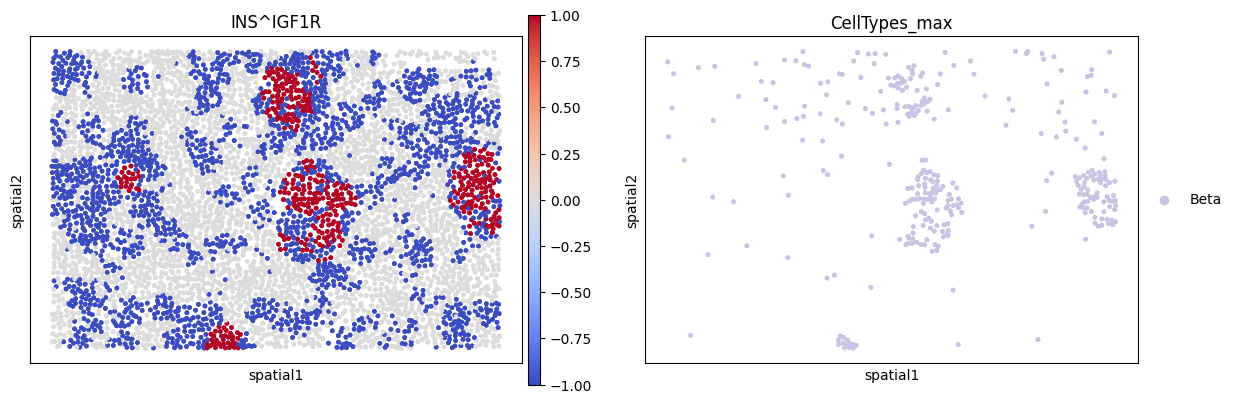

In [47]:
sq.pl.spatial_scatter(
    lrdata_nd,
    color = ['INS^IGF1R','CellTypes_max'],
    layer='cats',
    groups = ['Beta'],
    spatial_key = 'spatial',
    shape=None,
    cmap='coolwarm',
    ncols=2,
    #vmax="p99",
)

Here, we can distinguish areas in which the interaction between interaction members is positive (high-high) in Red (1), while interactions in which one is high the other is low or negative (High-low) are in Blue (-1). We also see that some interactions are neither, these are predominantly interactions in which both members are lowly-expressed (i.e. low-low); we see those in white (0).

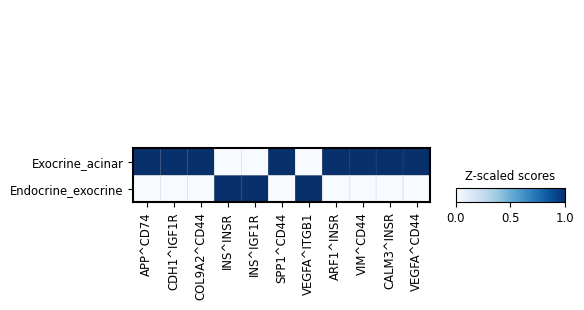

In [48]:
sc.pl.matrixplot(lrdata_nd, var_names=lrdata_nd.var_names, groupby='Niche_label', dendrogram=False, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Blues')

### Identify Intercellular Patterns  

Now that we have estimated ligand-receptor scores, we can use non-negative matrix factorization (NMF) to identify coordinated cell-cell communication signatures. This would ultimately decompose the ligand-receptor scores into a basis matrix (W) and a coefficient matrix (H). We will use a very simple utility function (around sklearn’s NMF implementation) to do so, along with a simple k (component number) selection procedure.

One limitation of NMF is that it requires the number of components (factors) to be specified - a somewhat an arbitrary choice. To aid the selection of n_components, we provide a simple function that estimates an elbow based on reconstruction error. Another limitation is that it only accepts non-negative values, so it won’t work with metrics that can be negative (e.g. Pearson correlation). In this case, we use Cosine similarity with non-negative values, which results also in non-negative local scores.

#### T1D FOV

In [49]:
li.multi.nmf(lrdata_t1, n_components=3, inplace=True, 
             random_state=0, max_iter=200, verbose=True)

# Extract the variable loadings
lr_loadings_t1 = li.ut.get_variable_loadings(lrdata_t1, 
                                          varm_key='NMF_H').set_index('index')


# Extract the factor scores
factor_scores_t1 = li.ut.get_factor_scores(lrdata_t1, obsm_key='NMF_W')

nmf_t1 = sc.AnnData(X=lrdata_t1.obsm['NMF_W'],
                 obs=lrdata_t1.obs,
                 var=pd.DataFrame(index=lr_loadings_t1.columns),
                 uns=lrdata_t1.uns,
                 obsm=lrdata_t1.obsm)

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


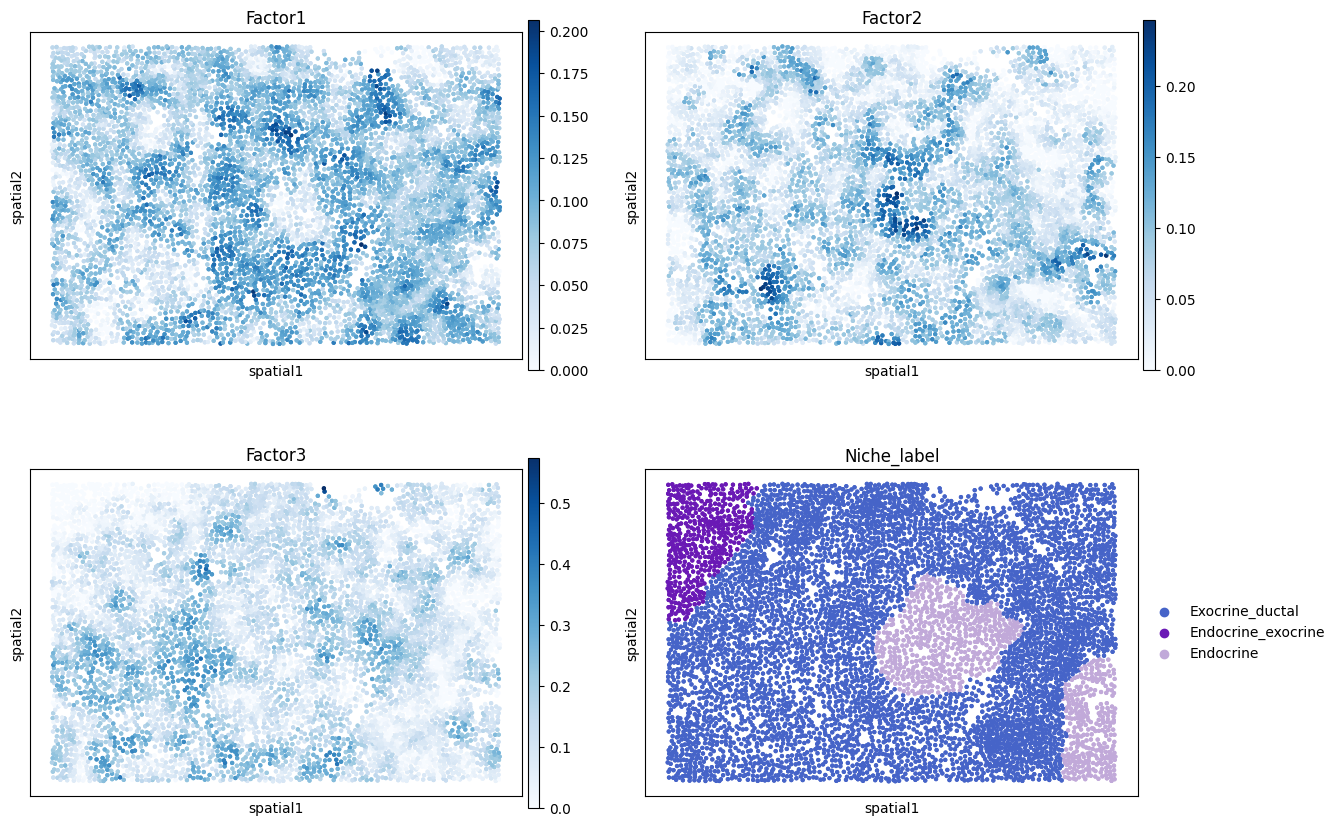

In [50]:
sq.pl.spatial_scatter(
    nmf_t1,
    color = [*nmf_t1.var.index,'Niche_label'],
    #groups = ['Endocrine'],
    spatial_key = 'spatial',
    shape=None,
    cmap='Blues',
    ncols=2,
    #vmax="p99",
)

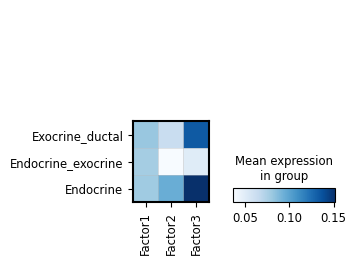

In [51]:
sc.pl.matrixplot(nmf_t1, var_names=nmf_t1.var_names, groupby='Niche_label', dendrogram=False,
                cmap='Blues')

We see that Factor 3 is mainly covering the Endocrine niche, let’s check the interactions contributing the most to it:

In [53]:
lr_loadings_t1.sort_values("Factor3", ascending=False).head(10)

Factor1   Factor2   Factor3
index                                         
MMP7^CD44         1.741661  0.000000  1.670555
S100A9^ITGB2      0.000000  0.778092  1.278799
S100A9^CD68       0.000000  1.036405  1.177965
COL4A2^ITGB5      0.639352  0.027616  1.017667
MIF^CD44_CD74     1.798794  0.459196  1.013418
LGALS9^CD47       0.425659  0.108815  0.929934
COL18A1^ITGA3     2.158859  0.000000  0.811921
SPP1^ITGAV_ITGB1  0.407506  0.431170  0.811679
LGALS3BP^ITGB1    1.069399  0.833371  0.797117
LGALS9^CD44       1.782886  0.254277  0.784397

#### ND FOV

In [54]:
li.multi.nmf(lrdata_nd, n_components=3, inplace=True, 
             random_state=0, max_iter=200, verbose=True)

# Extract the variable loadings
lr_loadings_nd = li.ut.get_variable_loadings(lrdata_nd, 
                                          varm_key='NMF_H').set_index('index')


# Extract the factor scores
factor_scores_nd = li.ut.get_factor_scores(lrdata_nd, obsm_key='NMF_W')

nmf_nd = sc.AnnData(X=lrdata_nd.obsm['NMF_W'],
                 obs=lrdata_nd.obs,
                 var=pd.DataFrame(index=lr_loadings_nd.columns),
                 uns=lrdata_nd.uns,
                 obsm=lrdata_nd.obsm)

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


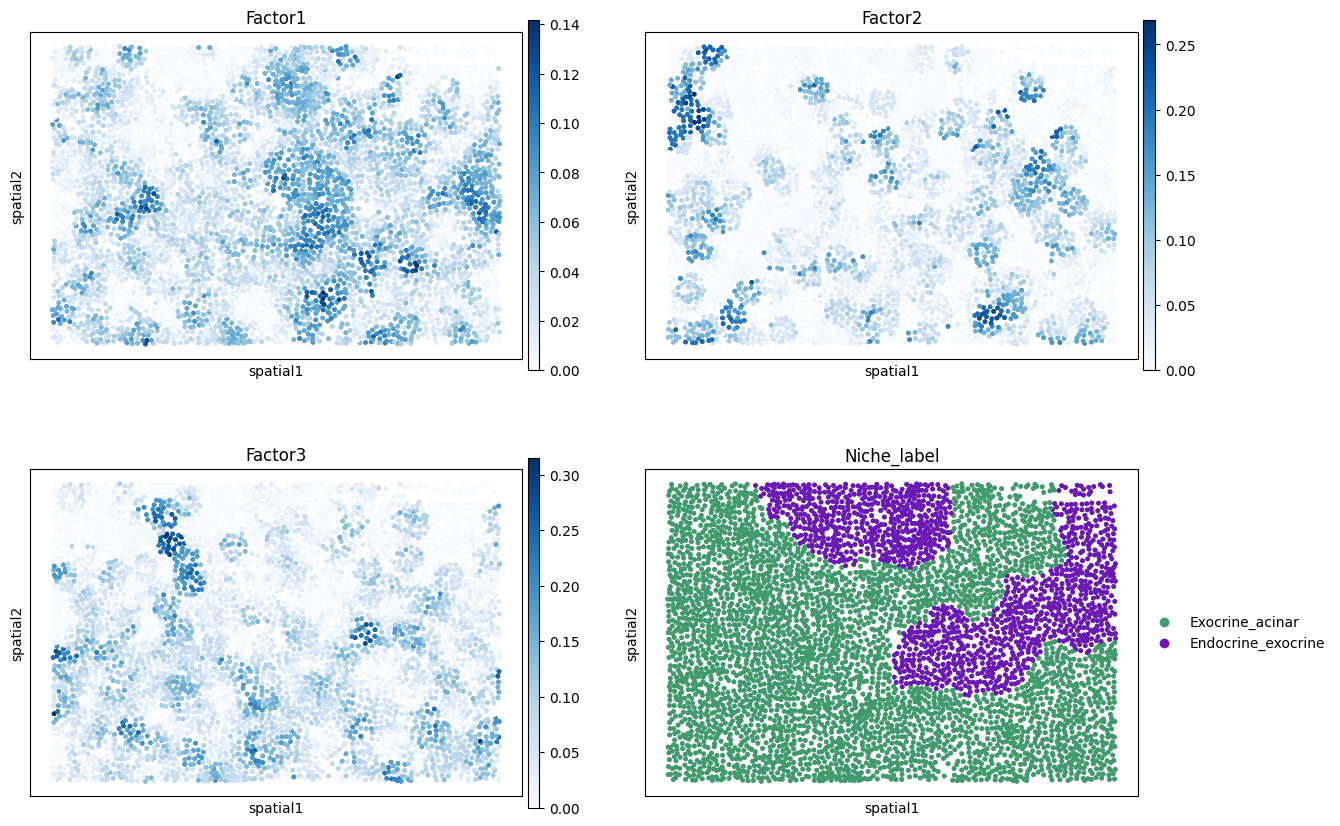

In [55]:
sq.pl.spatial_scatter(
    nmf_nd,
    color = [*nmf_nd.var.index,'Niche_label'],
    #groups = ['Endocrine'],
    spatial_key = 'spatial',
    shape=None,
    cmap='Blues',
    ncols=2,
    #vmax="p99",
)

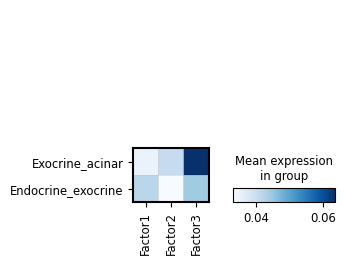

In [56]:
sc.pl.matrixplot(nmf_nd, var_names=nmf_nd.var_names, groupby='Niche_label', dendrogram=False,
                cmap='Blues')

We see that Factor 3 is mainly covering the islet areas of the fov, let’s check the interactions contributing the most to it:

In [57]:
lr_loadings_nd.sort_values("Factor1", ascending=False).head(10)

Factor1   Factor2   Factor3
index                                    
INS^IGF1R    4.648299  0.000000  0.000000
VEGFA^ITGB1  3.886601  0.151063  0.000000
INS^INSR     3.416048  0.002751  0.847930
CALM3^INSR   2.262344  0.212405  0.396559
APP^CD74     2.236400  1.351637  0.000000
ARF1^INSR    2.084001  0.244796  0.946480
VIM^CD44     0.862576  0.267223  1.437002
CDH1^IGF1R   0.556654  0.165434  1.802819
COL9A2^CD44  0.354752  0.521907  1.096453
SPP1^CD44    0.000000  4.183620  0.000000